# Water Mass Transformation Due to Mixing and Cabbeling #

I used the MITgcm to compute diffusive mixing on World Ocean Atlas 2013.

In this notebook, I load the results and perform the water mass transformation calculation.


In [1]:
import numpy as np
import xray
import dask.array as daskarray
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import SymLogNorm

In [2]:
import xgcm
import jmd95

In [3]:
iters = [1,]
ddir_woa = '/home/rpa/MITgcm/verification/global_oce_latlon_WOA/run'
ddir_cars = '/home/rpa/MITgcm/verification/global_oce_latlon_WOA/run.cars'
dsets = {}
dsets['WOA13'] = xgcm.open_mdsdataset(ddir_woa, iters, deltaT=86400, 
                             prefix=['DiagGAD-T', 'DiagGAD-S','DiagGAD-PTR','T','S']).chunk()
dsets['CARS'] = xgcm.open_mdsdataset(ddir_cars, iters, deltaT=86400, 
                             prefix=['DiagGAD-T', 'DiagGAD-S','DiagGAD-PTR','T','S']).chunk() 

xgcm/mdsxray.py:201: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
xgcm/mdsxray.py:201: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [7]:
def calc_mixing_and_cabbeling(ds):
    """Add mixing and cabbeling tendencies to Dataset ds"""
    
    mitgcm = xgcm.MITgcmDataset(ds)
    # compute divergence of diffusive fluxes for each tracer
    for v in ['_TH','_SLT','Tr01']:
        xflux = ds['DFxE' + v]
        yflux = ds['DFyE' + v]
        zfluxe = ds['DFrE' + v]
        zfluxi = ds['DFrI' + v]
        # need minus for convergence
        hdiff = -(mitgcm.diff_xp1_to_x(xflux) 
                + mitgcm.diff_yp1_to_y(yflux) )  * ds.HFacC
        vdiff = -(mitgcm.diff_zl_to_z(zfluxe) 
                + mitgcm.diff_zl_to_z(zfluxi)) * ds.HFacC
        v = v[1:] if v[0]=='_' else v
        ds[v + '_hdiff'] = hdiff
        ds[v + '_vdiff'] = vdiff
    assert 'Tr01_hdiff' in ds.variables

    # compute density factors
    T = np.array(ds['T'].data)
    S = np.array(ds['S'].data)
    rho0, drhodt, drhods = jmd95.eos.state_surface(T.ravel(), S.ravel())
    mask = (rho0<1000)
    rho0[mask] = np.nan
    drhodt[mask] = np.nan
    drhods[mask] = np.nan
    rho0.shape = T.shape
    drhodt.shape = T.shape
    drhods.shape = T.shape
    rho0 -= 1000.

    # add them to xray dataset
    ds['rho0'] = xray.DataArray( rho0, ds['T'].coords, ds['T'].dims).chunk()
    ds['drhodt'] = xray.DataArray( drhodt, ds['T'].coords, ds['T'].dims).chunk()
    ds['drhods'] = xray.DataArray( drhods, ds['T'].coords, ds['T'].dims).chunk()

    # calculate mixing and cabbeling tendencies in z coordinates
    # separate horizontal and vertical components
    ds['mixing'] = (ds.Tr01_hdiff + ds.Tr01_vdiff)
    ds['cabbeling_h'] = ( ds.drhods*ds.SLT_hdiff 
                        + ds.drhodt*ds.TH_hdiff
                        - ds.Tr01_hdiff)
    ds['cabbeling_v'] = ( ds.drhods*ds.SLT_vdiff 
                        + ds.drhodt*ds.TH_vdiff
                        - ds.Tr01_vdiff)
    ds['cabbeling'] = ds['cabbeling_h'] + ds['cabbeling_v']

def calc_water_mass_transformation(ds, rholevs, zrange=slice(0,-6000)):
    # transform to density space
    delta_rho = rholevs[1] - rholevs[0]
    ds['cab_rho'] = xgcm.regrid_vertical(ds.cabbeling.sel(Z=zrange),
                                   ds.TRAC01.sel(Z=zrange),
                                   rholevs, 'Z')/delta_rho
    ds['cab_rho_h'] = xgcm.regrid_vertical(ds.cabbeling_h.sel(Z=zrange),
                               ds.TRAC01.sel(Z=zrange),
                               rholevs, 'Z')/delta_rho
    ds['cab_rho_v'] = xgcm.regrid_vertical(ds.cabbeling_v.sel(Z=zrange),
                               ds.TRAC01.sel(Z=zrange),
                               rholevs, 'Z')/delta_rho
    ds['mix_rho'] = xgcm.regrid_vertical(ds.mixing.sel(Z=zrange),
                                   ds.TRAC01.sel(Z=zrange),
                                   rholevs, 'Z')/delta_rho
    ds['mix_rho_h'] = xgcm.regrid_vertical(ds.Tr01_hdiff.sel(Z=zrange),
                                   ds.TRAC01.sel(Z=zrange),
                                   rholevs, 'Z')/delta_rho
    ds['mix_rho_v'] = xgcm.regrid_vertical(ds.Tr01_vdiff.sel(Z=zrange),
                                   ds.TRAC01.sel(Z=zrange),
                                   rholevs, 'Z')/delta_rho


In [8]:
rholevs = np.linspace(24,28,60)
zmax = 6000
zrange=slice(0,-zmax)

atlases = ['WOA13', 'CARS']

for k in atlases:
    ds = dsets[k]
    calc_mixing_and_cabbeling(ds)
    calc_water_mass_transformation(ds, rholevs, zrange)

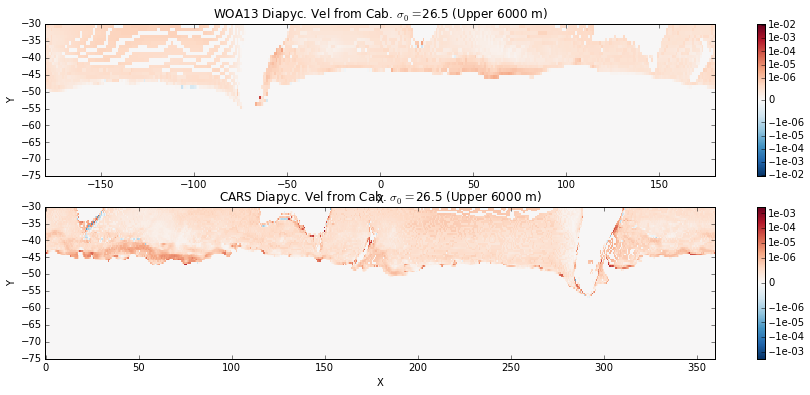

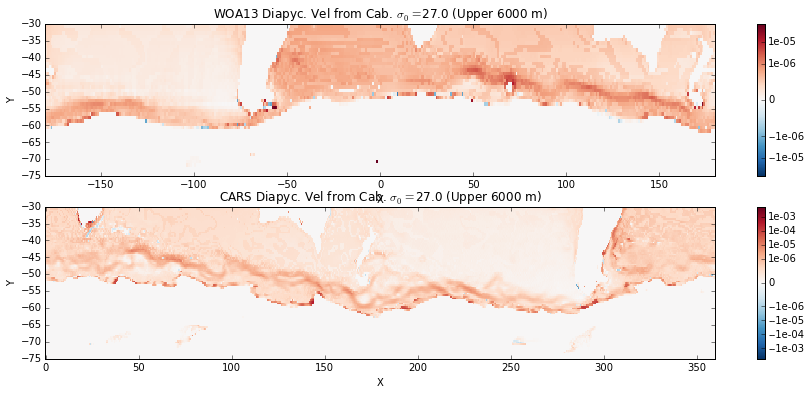

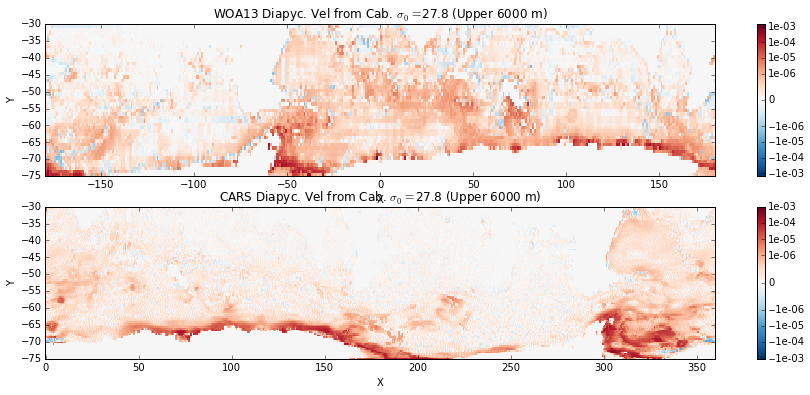

In [10]:
from matplotlib.ticker import SymmetricalLogLocator, LogFormatter
from matplotlib.scale import SymmetricalLogTransform

# plot on a specific isopycnal
for mysig0 in [26.5, 27.0, 27.8]:
    fig = plt.figure(figsize=(15,6))
    for n, k in enumerate(atlases):
        ds = dsets[k]
        ax = fig.add_subplot(2,1,n+1)
        a = (ds.cab_rho[0] / ds.rA).sel(TRAC01_coord=mysig0, method='nearest'
                                   ).plot.pcolormesh(
                    add_colorbar=False, norm=SymLogNorm(1e-7), ax=ax)
        plt.colorbar(a, ticks=SymmetricalLogLocator(SymmetricalLogTransform(10,1e-6,4)),
                        format=LogFormatter())
        #cb = a.colorbar
        #cb.set_ticks(SymmetricalLogLocator(1e-7))
        ax.set_title(k + ' Diapyc. Vel from Cab. $\sigma_0=$%3.1f (Upper %d m)' % (mysig0, zmax))
        ax.set_ylim(-75,-30)

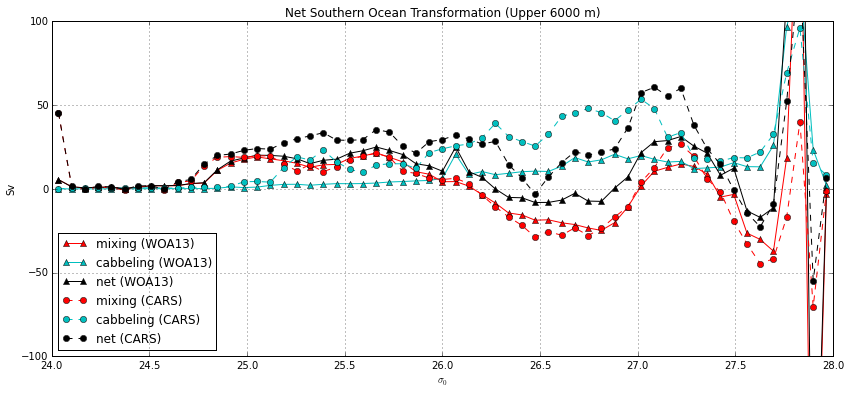

In [11]:
# plot net transformation
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)

for k, ls, m in zip(atlases, ['-', '--'], ['^','o']):
    ds = dsets[k]
    # net transformation in Southern Ocean
    cab_net = ds.cab_rho[0].sel(Y=slice(-80,-30)).sum(dim=('X','Y'))
    mix_net = ds.mix_rho[0].sel(Y=slice(-80,-30)).sum(dim=('X','Y'))


    (mix_net/1e6).plot.line(color='r', marker=m, linestyle=ls, ax=ax)
    (cab_net/1e6).plot.line(color='c', marker=m, linestyle=ls, ax=ax)
    ((mix_net+cab_net)/1e6).plot.line(color='k', marker=m, linestyle=ls, ax=ax)
    
ax.set_ylim([-100,100])
ax.grid()
leg = []
for k in atlases:
    leg += ['mixing (%s)' % k , 'cabbeling (%s)' % k, 'net (%s)' % k]
ax.legend(leg, loc='lower left')
ax.set_ylabel('Sv')
ax.set_xlabel(r'$\sigma_0$')
ax.set_title('Net Southern Ocean Transformation (Upper %d m)' % (zmax))

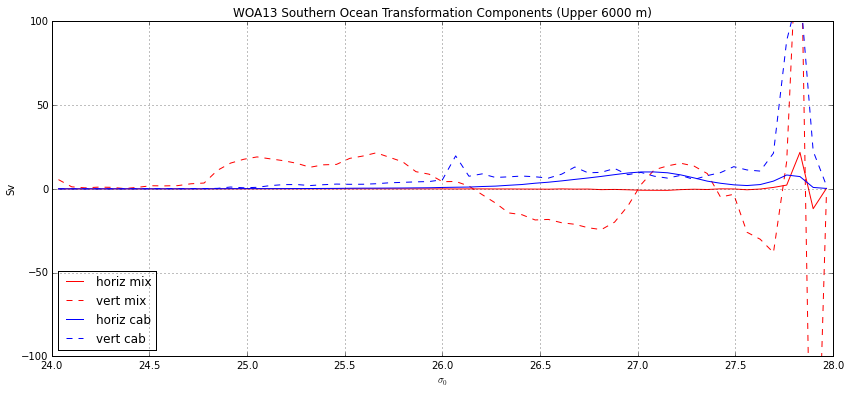

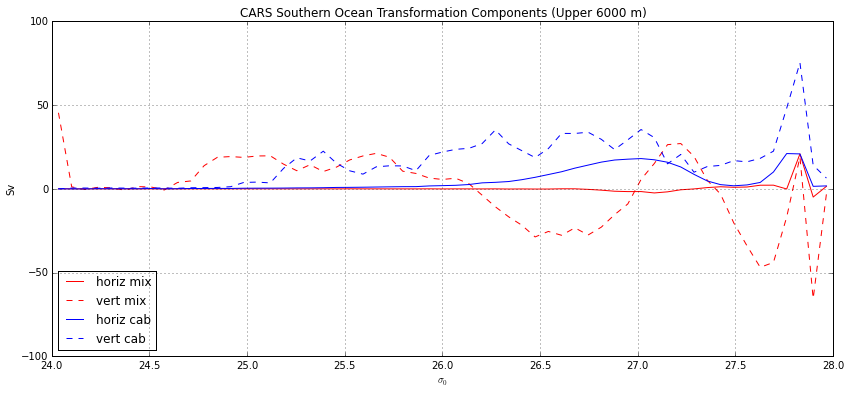

In [46]:
# break down into horizontal and vertical
for k in atlases:
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)

    ds = dsets[k]
    # net transformation in Southern Ocean
    cab_h = ds.cab_rho_h[0].sel(Y=slice(-80,-30)).sum(dim=('X','Y'))
    cab_v = ds.cab_rho_v[0].sel(Y=slice(-80,-30)).sum(dim=('X','Y'))
    mix_h = ds.mix_rho_h[0].sel(Y=slice(-80,-30)).sum(dim=('X','Y'))
    mix_v = ds.mix_rho_v[0].sel(Y=slice(-80,-30)).sum(dim=('X','Y'))

    (mix_h/1e6).plot.line(color='r', linestyle='-', ax=ax)
    (mix_v/1e6).plot.line(color='r', linestyle='--', ax=ax)
    (cab_h/1e6).plot.line(color='b', linestyle='-', ax=ax)
    (cab_v/1e6).plot.line(color='b', linestyle='--', ax=ax)
    
    ax.set_ylim([-100,100])
    ax.grid()
    leg = ['horiz mix', 'vert mix', 'horiz cab', 'vert cab']
    ax.legend(leg, loc='lower left')
    ax.set_ylabel('Sv')
    ax.set_xlabel(r'$\sigma_0$')
    ax.set_title('%s Southern Ocean Transformation Components (Upper %d m)' % (k,zmax))

# Volume Distribution #

The volume distribution function $V(\sigma_0)$ is normalized by the bin size, giving a results that is independent of the choice of density bin spacing.

In [34]:
def calc_volume(ds, rholevs, zrange=slice(0,-6000)):
    vol = ds.HFacC * ds.drF * ds.rA
    delta_rho = rholevs[1] - rholevs[0]
    ds['volume_rho'] = xgcm.regrid_vertical(vol.sel(Z=zrange),
                                   ds.TRAC01[0].sel(Z=zrange),
                                   rholevs, 'Z') / delta_rho
for ds in dsets.values():
    calc_volume(ds, rholevs)



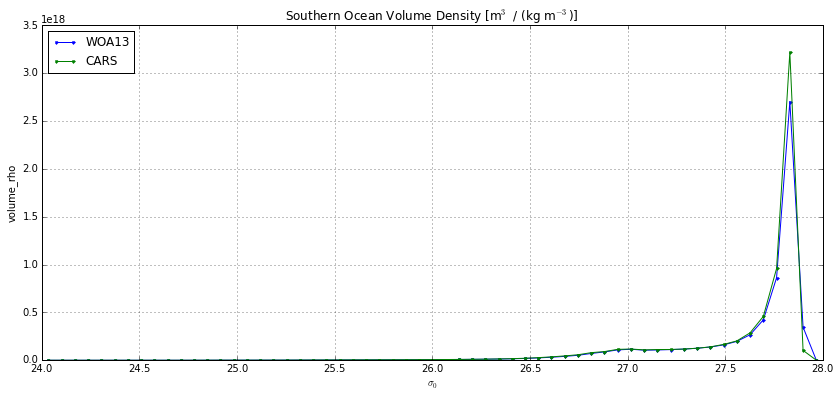

In [36]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)

for k in atlases:
    
    ds = dsets[k]
    # net transformation in Southern Ocean
    vol_net = ds.volume_rho.sel(Y=slice(-80,-30)).sum(dim=('X','Y'))
    vol_net.plot.line(marker='.')
    
plt.legend(atlases, loc='upper left')
plt.title(r'Southern Ocean Volume Density [m$^3$ / (kg m$^{-3}$)]')
ax.set_xlabel(r'$\sigma_0$')
ax.grid()

# Cumulative Distribution #

By integrating

$$ \int_{\sigma_{min}}^\sigma V(\sigma) d\sigma $$

we obtain the cumulative distribution function.

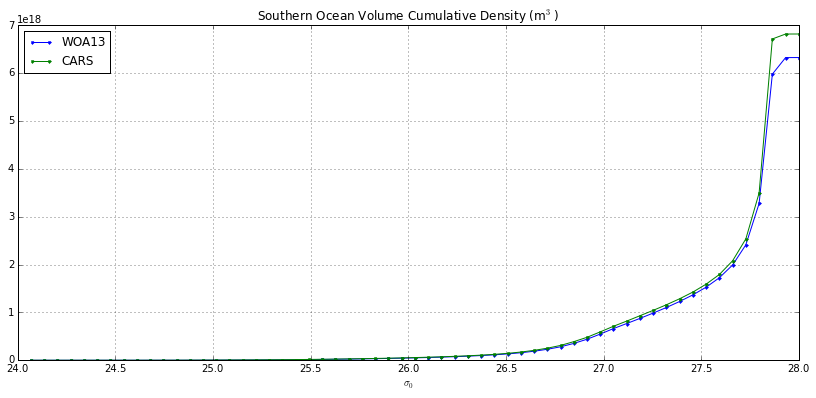

In [45]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)


for k in atlases:
    
    delta_rho = rholevs[1] - rholevs[0]
    ds = dsets[k]
    vol_net = ds.volume_rho.sel(Y=slice(-80,-30)).sum(dim=('X','Y'))
    vol_cum = vol_net.values.cumsum(axis=0)
    plt.plot(rholevs[1:], vol_cum, '.-')
    
plt.legend(atlases, loc='upper left')
plt.title(r'Southern Ocean Volume Cumulative Density (m$^3$)')
ax.set_xlabel(r'$\sigma_0$')
ax.grid()

# Vertical Diffusive Fluxes #

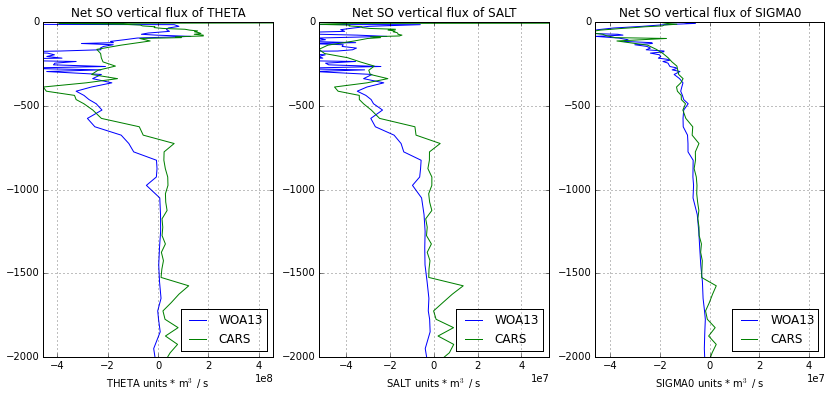

In [87]:
rk_sign = -1

plt.figure(figsize=(14,6))
for n, (name, k) in enumerate(zip(
                   ['THETA', 'SALT', 'SIGMA0'],
                   ['_TH', '_SLT', 'Tr01'])):

    ax = plt.subplot(1,3,n+1)
    for aname in dsets:
        ds  = dsets[aname]
        net_vflux = rk_sign*(
                        ds['DFrI' + k] + ds['DFrE' + k]
                    )[0].sel(Y=slice(-80,-30)).sum(dim=('X','Y'))
        plt.plot(net_vflux, net_vflux.Zl)

    ax.set_ylim([-2000,0])
    vmax = abs(net_vflux[5:]).max()
    ax.set_xlim([-vmax, vmax])
    plt.grid()
    plt.legend(atlases, loc='lower right')
    plt.title('Net SO vertical flux of %s' % name)
    plt.xlabel(r'%s units * m$^{3}$ / s' % name)

# Vertical Diffusive Heat Flux #

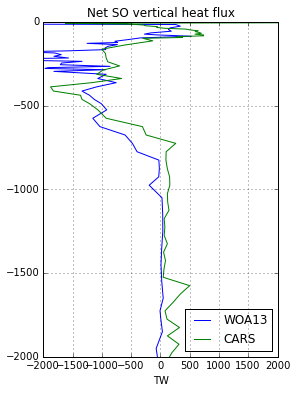

In [105]:
import gsw
rho0 = 1030

plt.figure(figsize=(4.2,6))

k = '_TH'
ax = plt.subplot(111)
for aname in dsets:
    ds  = dsets[aname]
    net_vflux = rk_sign*rho0*gsw.cp0*(
                    ds['DFrI' + k] + ds['DFrE' + k]
                )[0].sel(Y=slice(-80,-30)).sum(dim=('X','Y'))
    plt.plot(net_vflux/1e12, net_vflux.Zl)

ax.set_ylim([-2000,0])
vmax = 2000
ax.set_xlim([-vmax, vmax])
plt.grid()
plt.legend(atlases, loc='lower right')
plt.title('Net SO vertical heat flux')
plt.xlabel('TW')